# RAPA MVP Description

With RAPA, we plan to provide a robust, freely usable, and shareable tool for automated parsimony analysis.

RAPA will initially be developed on top of DataRobot’s Python API to use DataRobot as a "model-running engine." In the RAPA MVP, we will provide two primary features:

* Initial feature filtering to reduce a feature list down to a size that DataRobot can receive as input.

* Automated parsimony analysis to present to the user the trade-off between the size of Feature List and the best model performance on each Feature List, presented as a Pareto front.

Although the MVP implementation of these features will be based on basic techniques such as linear feature filters and recursive feature elimination, we plan to rapidly improve these features by integrating state-of-the-art techniques from the academic literature.

DataRobot API reference: https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.23.0/autodoc/api_reference.html

**The implementation below represents a quick first prototype that implements the core RAPA features.**

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict

from tqdm.notebook import tqdm

from sklearn.feature_selection import f_regression, f_classif
from sklearn.model_selection import StratifiedKFold, KFold
import datarobot as dr

pd.set_option('mode.chained_assignment', None)

In [2]:
datarobot_tokens = pickle.load(open('demo-data/dr-tokens.p', 'rb'))

dr.Client(endpoint='https://app.datarobot.com/api/v2',
          token=datarobot_tokens['RANDY'])

print('DataRobot API initiated')

DataRobot API initiated


In [31]:
def create_datarobot_submission(input_data_df, target_name, max_features=10000, n_splits=6, regression_threshold=10, random_state=None):
    input_data_df = input_data_df.copy()
    only_features_df = input_data_df.drop(columns=[target_name])

    # Target type is regression if the number of unique values meets or surpasses the regression threshold
    if input_data_df[target_name].nunique() >= regression_threshold:
        corr_func = f_regression
        kfold_type = KFold
        target_type = dr.enums.TARGET_TYPE.REGRESSION

    # Target type is classification if the number of unique values is lower than the regression threshold
    else:
        corr_func = f_classif
        kfold_type = StratifiedKFold

        if len(np.unique(input_data_df[target_name].values)) == 2:
            target_type = dr.enums.TARGET_TYPE.BINARY
        else:
            target_type = dr.enums.TARGET_TYPE.MULTICLASS

    input_data_df['partition'] = 'train'
    train_fvals = []
    for fold_num, (_, fold_indices) in enumerate(
        kfold_type(n_splits=n_splits, random_state=random_state, shuffle=True).split(only_features_df.values,
                                                                                     input_data_df[target_name].values)):
        input_data_df['partition'].iloc[fold_indices] = 'CV Fold {}'.format(fold_num)

        F_vals, _ = corr_func(only_features_df.iloc[fold_indices].values,
                              input_data_df[target_name].iloc[fold_indices].values)

        if fold_num > 0:
            train_fvals.append(F_vals)

    avg_train_fvals = np.mean(train_fvals, axis=0)

    input_data_df.loc[input_data_df['partition'] == 'CV Fold 0', 'partition'] = 'Holdout'

    most_correlated_features = only_features_df.columns.values[np.argsort(avg_train_fvals)[::-1][:max_features]]

    datarobot_upload_df = input_data_df[[target_name, 'partition'] + list(most_correlated_features)]

    return datarobot_upload_df, target_type

def submit_datarobot_project(input_data_df, target_name, target_type, project_name,
                             worker_count=-1, mode=dr.AUTOPILOT_MODE.QUICK,#.FULL_AUTO,
                             random_state=None):

    project = dr.Project.create(sourcedata=input_data_df, project_name=project_name)

    project.set_target(target=target_name, target_type=target_type,
                       # API NOTE: blend_best_models should be an advanced option, shouldn't it?
                       worker_count=worker_count, mode=mode, blend_best_models=False,
                       advanced_options=dr.AdvancedOptions(seed=random_state, accuracy_optimized_mb=False,
                                                           prepare_model_for_deployment=False)
                       partitioning_method=dr.UserCV(user_partition_col='partition', cv_holdout_level='Holdout'))

    return project

In [4]:
depression_targets = pd.read_pickle('demo-data/GSE128235_GPL13534_meta_data.pkl.gz')
depression_targets = depression_targets[['Sample_Name', 'diagnosis']]

depression_targets['Sample_Name'] = depression_targets['Sample_Name'].apply(lambda x: x.split('from ')[-1].replace(' ', ''))
depression_targets = depression_targets.sort_values('Sample_Name')
depression_targets = depression_targets.set_index('Sample_Name')

depression_targets['diagnosis'] = depression_targets['diagnosis'].apply(lambda x: np.NaN if x == 'NA' else x)

print(depression_targets.shape)
print('')
print(depression_targets['diagnosis'].value_counts(dropna=False))
print('')

depression_targets.head()

(537, 1)

case       324
control    209
NaN          4
Name: diagnosis, dtype: int64



,diagnosis
Sample_Name,
sample1,case
sample10,case
sample100,case
sample101,case
sample102,case


In [5]:
depression_probes = pd.read_pickle('demo-data/GSE128235_published_beta_values.pkl.gz')
depression_probes = depression_probes.transpose()

print(depression_probes.shape)
print('')
print('Number probe values missing: {}'.format(depression_probes.isnull().values.sum()))
print('')

depression_probes.head()

(537, 424958)

Number probe values missing: 0



ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,ch.9.90621653R,ch.9.93373462R,ch.9.93402636R,ch.9.941347R,ch.9.96055087R,ch.9.98463211R,ch.9.98936572R,ch.9.98937537R,ch.9.98957343R,ch.9.98989607R
sample1,0.326818,0.879197,0.468160,0.146588,0.448943,0.502265,0.873614,0.311076,0.475424,0.018955,...,0.049002,0.016097,0.058038,0.074234,0.197355,0.027904,0.129527,0.029709,0.044150,0.206440
sample10,0.415210,0.907214,0.557319,0.233235,0.736620,0.460241,0.824549,0.147720,0.336983,0.016009,...,0.038740,0.020897,0.029848,0.037481,0.203643,0.038363,0.080692,0.021716,0.032436,0.050670
sample100,0.765856,0.844815,0.441327,0.246168,0.678574,0.523411,0.797574,0.358016,0.337046,0.011921,...,0.131987,0.020495,0.054040,0.065623,0.217844,0.037159,0.104665,0.036617,0.039345,0.088958
sample101,0.325327,0.900210,0.550631,0.123783,0.694306,0.447073,0.745615,0.172808,0.336132,0.014005,...,0.041405,0.015561,0.024096,0.044807,0.144187,0.033617,0.080591,0.017461,0.040946,0.048543
sample102,0.535994,0.900743,0.705987,0.160707,0.728889,0.547176,0.845196,0.227794,0.291751,0.012642,...,0.043204,0.017191,0.025321,0.041597,0.189545,0.027423,0.078994,0.014146,0.035943,0.018085


In [6]:
depression_df = depression_probes.join(depression_targets)
print('Shape after join: {}'.format(depression_df.shape))

depression_df = depression_df.dropna()
print('Shape after dropna: {}'.format(depression_df.shape))

depression_df.head()

Shape after join: (537, 424959)
Shape after dropna: (533, 424959)


,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,ch.9.93373462R,ch.9.93402636R,ch.9.941347R,ch.9.96055087R,ch.9.98463211R,ch.9.98936572R,ch.9.98937537R,ch.9.98957343R,ch.9.98989607R,diagnosis
sample1,0.326818,0.879197,0.468160,0.146588,0.448943,0.502265,0.873614,0.311076,0.475424,0.018955,...,0.016097,0.058038,0.074234,0.197355,0.027904,0.129527,0.029709,0.044150,0.206440,case
sample10,0.415210,0.907214,0.557319,0.233235,0.736620,0.460241,0.824549,0.147720,0.336983,0.016009,...,0.020897,0.029848,0.037481,0.203643,0.038363,0.080692,0.021716,0.032436,0.050670,case
sample100,0.765856,0.844815,0.441327,0.246168,0.678574,0.523411,0.797574,0.358016,0.337046,0.011921,...,0.020495,0.054040,0.065623,0.217844,0.037159,0.104665,0.036617,0.039345,0.088958,case
sample101,0.325327,0.900210,0.550631,0.123783,0.694306,0.447073,0.745615,0.172808,0.336132,0.014005,...,0.015561,0.024096,0.044807,0.144187,0.033617,0.080591,0.017461,0.040946,0.048543,case
sample102,0.535994,0.900743,0.705987,0.160707,0.728889,0.547176,0.845196,0.227794,0.291751,0.012642,...,0.017191,0.025321,0.041597,0.189545,0.027423,0.078994,0.014146,0.035943,0.018085,case


In [15]:
datarobot_df, target_type = create_datarobot_submission(input_data_df=depression_df, target_name='diagnosis', max_features=1000, random_state=7)

In [16]:
print(datarobot_df.shape)
datarobot_df.head()

(533, 1002)


,diagnosis,partition,cg24162270,cg22022716,cg07319315,cg07052231,cg03714676,cg24501381,cg02558476,cg02368812,...,cg25618559,cg13977235,cg05099952,cg11893955,cg05074138,cg10271819,cg15572396,cg12299361,cg17972213,cg13255542
sample1,case,CV Fold 1,0.517648,0.595226,0.399425,0.335528,0.313803,0.321657,0.175515,0.334059,...,0.668022,0.325996,0.216434,0.741337,0.757498,0.314397,0.448263,0.343139,0.812276,0.342943
sample10,case,CV Fold 5,0.630684,0.551483,0.706200,0.538894,0.499183,0.510002,0.333609,0.650298,...,0.552385,0.324738,0.442059,0.605909,0.769894,0.288033,0.390572,0.409645,0.797718,0.415318
sample100,case,CV Fold 5,0.605335,0.637301,0.465452,0.356287,0.520019,0.268641,0.167603,0.576511,...,0.785945,0.327485,0.327550,0.858515,0.854338,0.340011,0.281975,0.311284,0.766967,0.482798
sample101,case,CV Fold 5,0.369526,0.400331,0.557621,0.329450,0.379638,0.351723,0.246707,0.408492,...,0.821053,0.289546,0.334397,0.863657,0.765856,0.174837,0.251411,0.236231,0.735811,0.306729
sample102,case,CV Fold 4,0.575407,0.605633,0.682896,0.553338,0.509613,0.493481,0.320425,0.517682,...,0.597014,0.378126,0.472080,0.663319,0.682737,0.344660,0.413287,0.375873,0.644732,0.354745


In [17]:
datarobot_project = submit_datarobot_project(input_data_df=datarobot_df, target_name='diagnosis', target_type=target_type, project_name='RAPA Test Project', random_state=7)

In [18]:
datarobot_project

Project(RAPA Test Project)

In [28]:
# API NOTE: Would be nice to have a progress bar here instead of print output
datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)

In [33]:
datarobot_project.get_featurelists()

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections),
 Featurelist(DR Reduced Features M7)]

In [42]:
project_feature_importances = pd.DataFrame([(feature.name, feature.importance) for feature in datarobot_project.get_features()],
                                           columns=['Feature', 'Importance'])

project_feature_importances = project_feature_importances.sort_values('Importance', ascending=False)

print(project_feature_importances.shape)
project_feature_importances.head()

(1002, 2)


,Feature,Importance
997,diagnosis,1.000000
377,cg07319315,0.094928
882,cg06355720,0.078186
205,cg14230719,0.073533
178,cg05071334,0.071797


In [56]:
baseline_features_df = project_feature_importances.loc[project_feature_importances['Importance'] > 0.]
baseline_features = baseline_features_df['Feature'].values.tolist()

baseline_featurelist = datarobot_project.create_featurelist(name='RAPA Baseline', features=baseline_features)

In [53]:
# API NOTE: Why isn't Quick Autopilot available here?
datarobot_project.start_autopilot(featurelist_id=baseline_featurelist.id, mode=dr.AUTOPILOT_MODE.FULL_AUTO, blend_best_models=False, prepare_model_for_deployment=False)

In [66]:
datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)

In [101]:
for feature_pct in tqdm(np.arange(0.95, 0.04, -0.1)):
    try:
        reduced_features = baseline_features_df.head(round(baseline_features_df.shape[0] * feature_pct))['Feature'].values.tolist()
        reduced_featurelist = datarobot_project.create_featurelist(name='RAPA Reduced to {}'.format(len(reduced_features)), features=reduced_features)
        datarobot_project.start_autopilot(featurelist_id=reduced_featurelist.id, mode=dr.AUTOPILOT_MODE.FULL_AUTO, blend_best_models=False, prepare_model_for_deployment=False)
        datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)
    except dr.errors.ClientError as e:
        if 'Feature list named' in str(e) and 'already exists' in str(e):
            continue
        else:
            raise e

/Users/rolson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [143]:
for feature_pct in tqdm(np.arange(0.04, 0.001, -0.01)):
    try:
        reduced_features = baseline_features_df.head(round(baseline_features_df.shape[0] * feature_pct))['Feature'].values.tolist()
        reduced_featurelist = datarobot_project.create_featurelist(name='RAPA Reduced to {}'.format(len(reduced_features)), features=reduced_features)
        datarobot_project.start_autopilot(featurelist_id=reduced_featurelist.id, mode=dr.AUTOPILOT_MODE.FULL_AUTO, blend_best_models=False, prepare_model_for_deployment=False)
        datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)
    except dr.errors.ClientError as e:
        if 'Feature list named' in str(e) and 'already exists' in str(e):
            continue
        else:
            raise(e)

In [144]:
datarobot_project_models = datarobot_project.get_models()

In [145]:
featurelist_performances = defaultdict(list)

for model in datarobot_project_models:
    if 'RAPA Reduced' not in model.featurelist_name:
        continue
    
    num_features = int(model.featurelist_name.split(' ')[-1])
    featurelist_performances[num_features].append(model.metrics['AUC']['crossValidation'])

featurelist_performances_df = pd.DataFrame(featurelist_performances)[sorted(featurelist_performances.keys())]
featurelist_performances_df = featurelist_performances_df.dropna()
featurelist_performances_df

,9,17,26,34,43,128,213,299,384,469,554,640,725,810
0,0.691352,0.680594,0.672690,0.661514,0.673792,0.668556,0.665274,0.659266,0.650506,0.649264,0.641918,0.636482,0.637526,0.651994
1,0.681558,0.689100,0.650482,0.673366,0.676522,0.672624,0.658102,0.665172,0.627852,0.651686,0.652600,0.642982,0.633636,0.644148
2,0.700280,0.646804,0.691098,0.692042,0.668772,0.660530,0.661204,0.653702,0.648462,0.639984,0.642136,0.645012,0.638348,0.633496
3,0.687078,0.646674,0.648976,0.662972,0.653738,0.684196,0.669762,0.667396,0.649174,0.646942,0.629216,0.639488,0.640228,0.636588
4,0.660050,0.653798,0.659798,0.654416,0.691886,0.671356,0.655116,0.652020,0.651486,0.648130,0.642208,0.629006,0.635260,0.622070
5,0.679360,0.647474,0.642732,0.651232,0.681224,0.675394,0.669310,0.662130,0.641770,0.645984,0.639660,0.617270,0.640250,0.626790
6,0.681882,0.651706,0.649518,0.656522,0.671972,0.644556,0.645120,0.656988,0.636132,0.651158,0.627578,0.609694,0.622106,0.680384
7,0.692186,0.667344,0.659610,0.676544,0.673776,0.671116,0.653562,0.639912,0.648514,0.655754,0.700514,0.623046,0.619086,0.633858


''

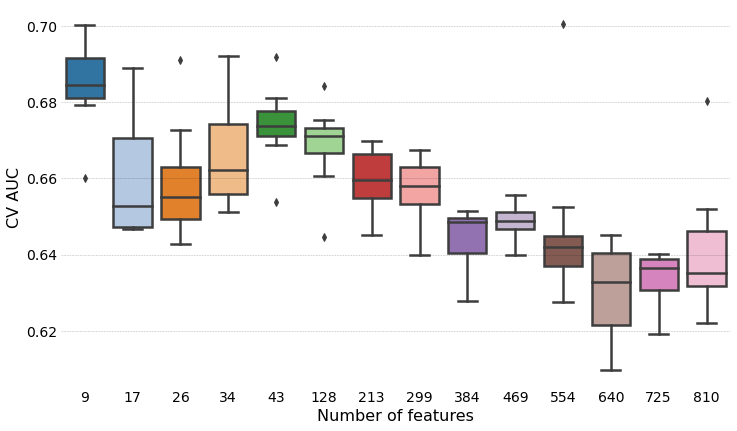

In [148]:
with plt.style.context('tableau20'):
    sb.boxplot(data=featurelist_performances_df)
    plt.ylabel('CV AUC')
    plt.xlabel('Number of features')
;

''

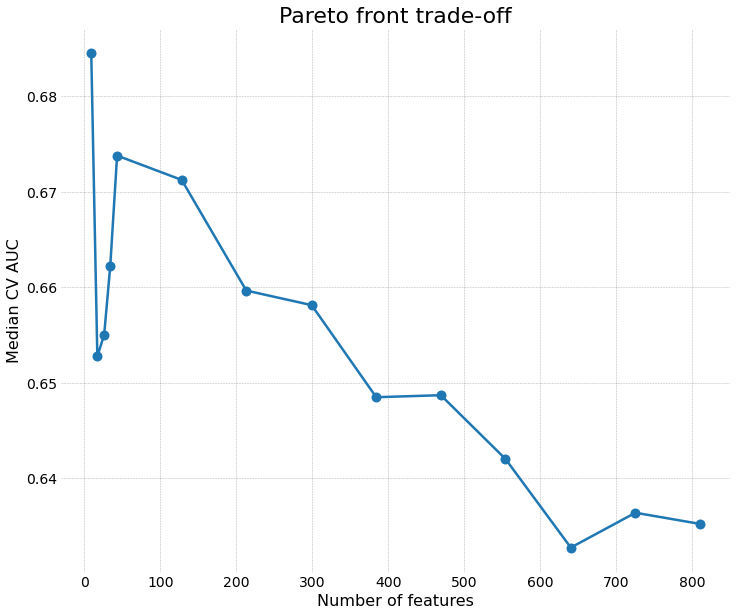

In [149]:
with plt.style.context('tableau10'):
    plt.figure(figsize=(12, 10))
    feature_nums = featurelist_performances_df.median().index.values
    medians = featurelist_performances_df.median().values
    plt.plot(feature_nums, medians, 'o-')

    plt.ylabel('Median CV AUC')
    plt.xlabel('Number of features')
    plt.title('Pareto front trade-off')
;